# Bayes 3D Image Likelihood constrained to rays

In [1]:
#|default_exp likelihood

In [2]:
#|export
import jax
from jax import (jit, vmap)
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import genjax

In [3]:
#|export
from scipy.stats import truncnorm as scipy_truncnormal

normal_logpdf = jax.scipy.stats.norm.logpdf
truncnorm_pdf = jax.scipy.stats.truncnorm.pdf
truncnorm_logpdf = jax.scipy.stats.truncnorm.logpdf
logsumexp = jax.scipy.special.logsumexp


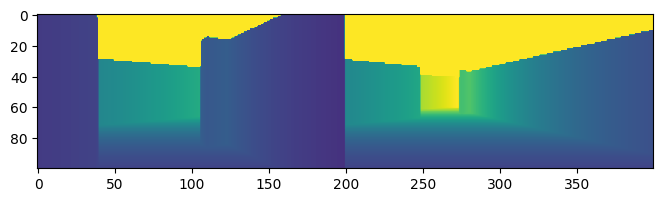

In [4]:
imgs = []
for t in range(10):
    im = np.load(f"./data/test_imgs/img_{t}.npy")
    imgs.append(jnp.array(im))

imgs = jnp.array(imgs)
imgs.shape


X = imgs[10,:,:,:3]
Y = imgs[2,:,:,:3]

plt.figure(figsize=(8,2))
plt.imshow(jnp.concatenate([X[:,:,2],Y[:,:,2]], axis=1), vmin=0., vmax=5)

In [5]:
#|export
def get_1d_mixture_components(x, ys, sig):

    # 1D-Mixture components and value to evaluate.
    # These are given by the distances ALONG ray through `x`
    d  = jnp.linalg.norm(x)
    ds = ys @ x / d
    
    # 1D-Mixture weights.
    # First compute the distances TO ray through `x`
    # and then transforming them appropriately.
    ws = jnp.linalg.norm(ds[...,None] * x/d - ys, axis=-1)
    ws = normal_logpdf(ws, loc=0.0, scale=sig)
    ws = jnp.where(ws == -100., -jnp.inf, ws)
    ws = ws - logsumexp(ws)

    return d, ds, ws

In [6]:
#|export
# Some helper to keep code concise
def dslice(X, i,j, w): 
    return  jax.lax.dynamic_slice(X, (i, j, 0), (2*w + 1, 2*w + 1, 3))   

def adjusted_dslice(X, i,j, w): 
    i_ = jnp.maximum(i-w, 0)
    j_ = jnp.maximum(j-w, 0)
    return  jax.lax.dynamic_slice(X, (i_, j_, 0), (2*w + 1, 2*w + 1, 3))    

def pad(X, w):
    return jax.lax.pad(X,  -100., ((w,w,0),(w,w,0),(0,0,0)))

pad_jit = jit(pad, static_argnames=("w",))

def mix_std(ps, mus, stds):
    """Standard Deviation of a mixture of Gaussians."""
    return jnp.sqrt(jnp.sum(ps*stds**2) + jnp.sum(ps*mus**2) - (jnp.sum(ps*mus))**2)

In [7]:
#|export
def img_mean_and_var(X, zmax, sig, w):

    # Pixel-wise mean and var
    def mean_and_var_ij(i,j):        

        x  = X[i, j, :3]
        ys = dslice(pad(X,w), i,j, w)
        # ys = adjusted_dslice(X,i,j,w)

        d, ds, ws = get_1d_mixture_components(x, ys, sig)

        mu  = jnp.sum(jnp.exp(ws)*ds)
        std = mix_std(jnp.exp(ws), ds, sig)

        return mu, std**2

    I, J = jnp.mgrid[:X.shape[0], :X.shape[1]]
    I = I.ravel()
    J = J.ravel()

    mu, var = vmap(mean_and_var_ij)(I, J)
    return mu.reshape(*X.shape[:2]), var.reshape(*X.shape[:2])

(100, 200)
1.2828391


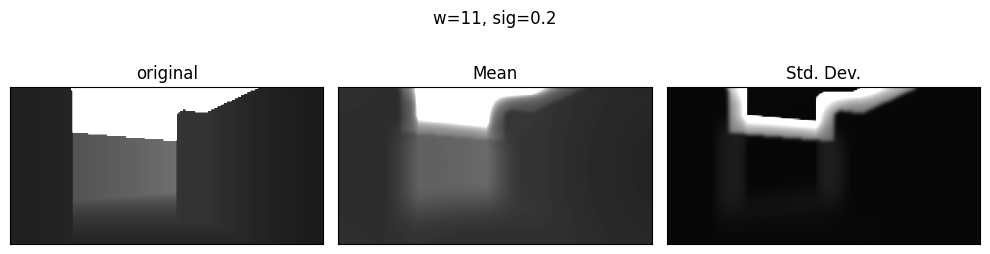

In [8]:
zmax = 20.0
sig  = .2
out  = 0.1
w    = 11

mu, var  = img_mean_and_var(X, zmax, sig, w)
std = jnp.sqrt(var)
print(mu.shape)
print(mu[0,0])

# -------------------------
vmin = 0.
vmax = 7.
fig, axs = plt.subplots(1,3, figsize=(10,3))
fig.suptitle(f"w={w}, sig={sig}")
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

axs[0].set_title("original")
axs[0].imshow(X[:,:,2], vmin=vmin, vmax=vmax, cmap="binary_r")
axs[1].set_title("Mean")
axs[1].imshow(mu, vmin=vmin, vmax=vmax, cmap="binary_r")
axs[2].set_title("Std. Dev.")
axs[2].imshow(std, vmin=vmin, vmax=vmax, cmap="binary_r");
fig.tight_layout(rect=[0, 0.03, 1., 1.])

In [48]:
#|export
import functools


def constrained_lh_mix(x, ys, zmax=100.0, sig=0.1):
    d, ds, ws = get_1d_mixture_components(x, ys, sig)
    
    logps = truncnorm_logpdf(d, (0.0 - ds)/sig, (zmax - ds)/sig, loc=ds, scale=sig)
    logp  = logsumexp(logps + ws)
    
    return logp


def constrained_lh_mix_ij(i,j, X, Y_padded, zmax=100.0, sig=0.1, w=7):
    x  = X[i, j, :3]
    ys = dslice(Y_padded, i,j, w)

    return constrained_lh_mix(x, ys, zmax=zmax, sig=sig)


def or_outlier(logp, outlier, zmax):
    return jnp.logaddexp(logp + jnp.log(1.0 - outlier), jnp.log(outlier) - jnp.log(zmax))


def constrained_lh(X, Y, zmax, sig, outlier, w:int):
    """"Likelihood of observation X conditioned on Y."""
    # Y_   = jax.lax.pad(Y,  -100., ((w,w,0),(w,w,0),(0,0,0)) )
    Y_ = pad_jit(Y,w)
    
    I, J = jnp.meshgrid(jnp.arange(X.shape[0]), jnp.arange(X.shape[1]))
    I = I.ravel()
    J = J.ravel()

    f_ij = lambda i,j: constrained_lh_mix_ij(i, j, X[:,:,:3], Y_[:,:,:3], zmax, sig, w) 
    logps = jax.vmap(f_ij)(I, J)
    
    logps = or_outlier(logps, outlier, zmax)
    return logps.sum()


constrained_lh_jit = jit(constrained_lh,static_argnames=("w",))

In [44]:
X = imgs[10,:,:,:]
Y = imgs[2,:,:,:]
zmax=20.
sig=0.2
outlier=0.1
w= 5
args = (zmax, sig, outlier, w)

constrained_lh(X, Y, *args)
%timeit -n 1 -r 1 constrained_lh(X, Y, *args);

237 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [50]:
pad_jit(X, w);

In [46]:
#|export
from genjax.generative_functions.distributions import ExactDensity

class B3DImageLikelihood(ExactDensity):
    def sample(self, key, Y, zmax, sig, outlier, w:int):
        # TODO: write this method
        return Y

    def logpdf(self, X, Y, zmax, sig, outlier, w:int):
        return constrained_lh_jit(X, Y, zmax, sig, outlier, w)

b3d_image_likelihood = B3DImageLikelihood()


## Testing

In [21]:
zmax = 100.0
sig = 0.1
out = 0.1
w = 21

constrained_lh(X, Y, zmax, sig, out, w)

Array(-5920.58, dtype=float32)

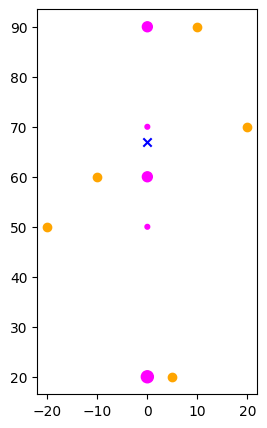

In [22]:
zmax = 100.0
sig = 10.0

x  = jnp.array([0.,67.,0.])
ys = jnp.array([ 
    [-20, 50, 0],
    [-10, 60, 0],
    [10, 90, 0],
    [20, 70, 0],
    [5, 20, 0],
])


z = jnp.linalg.norm(x)

zs_ = ys @ x / z
ws_ = jnp.linalg.norm(zs_[...,None] * x/z - ys, axis=-1)
ws_ = normal_logpdf(ws_, loc=0.0, scale=sig)
ws_ = ws_ - logsumexp(ws_)
logps = truncnorm_logpdf(z, (0.0 - zs_)/sig, (zmax - zs_)/sig, loc=zs_, scale=sig)
logp  = logsumexp(logps + ws_)


vs = zs_[...,None] * x/z



# ------------------------------
plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
plt.scatter(ys[:,0], ys[:,1], c="orange")
plt.scatter(vs[:,0], zs_,  s=jnp.exp(ws_)*2_00, c="magenta")
plt.scatter(x[0], z, marker="x", c="blue");

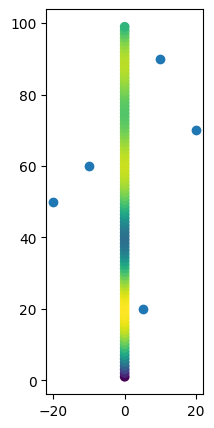

In [23]:
xs = jnp.linspace(0.0, zmax, 100)[:,None] * x/z


ps = vmap(lambda x: constrained_lh_mix(x, ys, zmax=100.0, sig=10.))(xs)

plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
plt.scatter(xs[:,0], xs[:,1], c = ps)
plt.scatter(ys[:,0], ys[:,1])

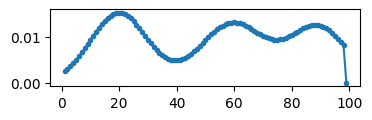

In [24]:
plt.figure(figsize=(4,1))
plt.plot(jnp.exp(ps), marker=".")

In [84]:
imgs = []
for t in range(10):
    im = np.load(f"./data/test_imgs/img_{t}.npy")
    imgs.append(jnp.array(im))

imgs = jnp.array(imgs)
imgs.shape


X = imgs[3]
Y = imgs[2]


plt.imshow(jnp.concatenate([X[:,:,2],Y[:,:,2]]), vmin=0., vmax=5)

(10, 100, 200, 4)

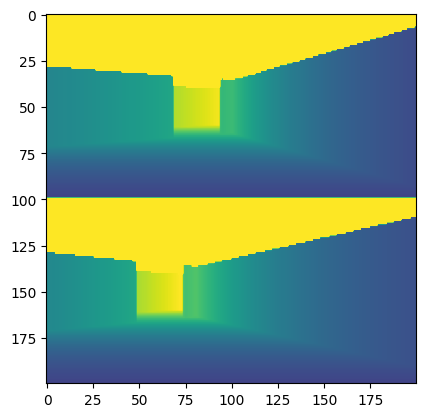

(43, 43)


Array(-5920.5806, dtype=float32)

In [93]:


# J, I = jnp.meshgrid(jnp.arange(X.shape[1]), jnp.arange(X.shape[0]))
# I.shape, J.shape
# jj, ii = jnp.meshgrid(jnp.arange(X.shape[1]), jnp.arange(X.shape[0]))
# indices = jnp.stack([ii,jj],axis=-1)
# indices.shape